In [1]:
# Imports
import os
import cv2
import random
import numpy as np

from load_data import *

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import keras
from keras import layers, regularizers, optimizers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Import real fingerprint images

### Load the data

In [2]:
REAL = '/mnt/c/Users/Meekmar/Github/finger-prints/SOCOFing/Real'

# Load the data | (img, (gender-label, hand-label, finger-lable))
data = imageImport(REAL)

#### Gender train-val-test split

In [3]:
# Splits the train-test in the same way as the paper did (I added an additional train-validation split for tuning of the model)
X_gender_train, X_gender_val, X_gender_test, y_gender_train, y_gender_val, y_gender_test = genderTrainTestSplit(data, 1000, 230)

In [4]:
X_gender_train.shape, X_gender_val.shape

((1400, 103, 96), (600, 103, 96))

In [5]:
len(X_gender_train), len(X_gender_val), len(X_gender_test), len(y_gender_train), len(y_gender_val), len(y_gender_test)

(1400, 600, 460, 1400, 600, 460)

#### Hand train-val-test split

In [43]:
# hand_data = [(datapoint[0], datapoint[1][1]) for datapoint in data]
# random.shuffle(hand_data)

# X_hand, y_hand = zip(*hand_data)

# X_hand_train, X_hand_test, y_hand_train, y_hand_test = train_test_split(X_hand, y_hand, test_size=0.15, shuffle=True, stratify=y_hand)

# X_hand_train, X_hand_val, y_hand_train, y_hand_val = train_test_split(X_hand_train, y_hand_train, test_size=0.1764705, shuffle=True, stratify=y_hand_train)

#### Finger train-val-test split

In [44]:
# finger_data = [(datapoint[0], datapoint[1][2]) for datapoint in data]
# random.shuffle(finger_data)

# X_finger, y_finger = zip(*finger_data)

# X_finger_train, X_finger_test, y_finger_train, y_finger_test = train_test_split(X_finger, y_finger, test_size=0.15, shuffle=True, stratify=y_finger)

# X_finger_train, X_finger_val, y_finger_train, y_finger_val = train_test_split(X_finger_train, y_finger_train, test_size=0.1764705, shuffle=True, stratify=y_finger_train)

### Plotting

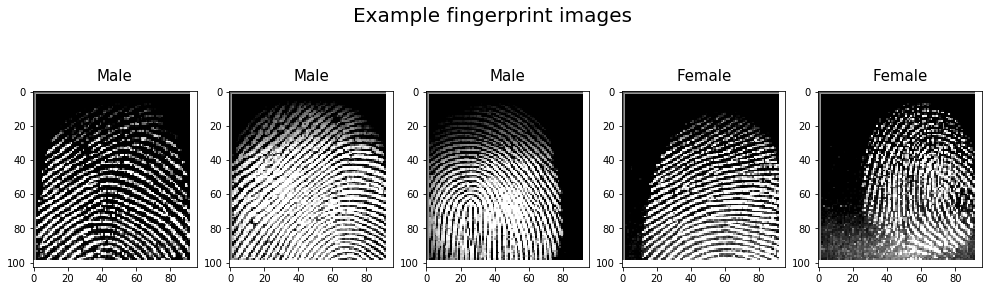

In [6]:
def plot_images(X, y, title='Example fingerprint images'):
    fig, axes = plt.subplots(1, len(X), figsize=(17, 5))
    
    for idx, ax in enumerate(axes):
        #ax.axis('off')
        ax.imshow(X[idx], cmap='gray_r')
        ax.set_title('Male' if y[idx] == 1 else 'Female', size=15, pad=10)
        
    fig.suptitle(title, fontsize=20)

random_sample = random.sample(range(1000), 5)
plot_images(X_gender_train[random_sample], y_gender_train[random_sample])

### RANDOM MODEL

In [7]:
# Reshape the input arrays
X_gender_train = np.array(X_gender_train).reshape(-1, 103, 96, 1)
X_gender_val = np.array(X_gender_val).reshape(-1, 103, 96, 1)
X_gender_test = np.array(X_gender_test).reshape(-1, 103, 96, 1)

#### Experiment 1

In [47]:
# Build some random initial model
model_1 = keras.Sequential()

model_1.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2)))
model_1.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(units=16, activation='relu'))
model_1.add(layers.Dense(units=8, activation='relu'))
model_1.add(layers.Dense(units=1, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                270352    
_________________________________________________________________
dense_13 (Dense)             (None, 8)                

In [49]:
# Result of first randomly initialized model
history_1 = model_1.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

#### Plot function

In [8]:
def plotHistory(History):
    '''Generates two plots: (1) the train accuracy vs. validation accuracy and (2) train loss vs. validation loss.'''
    sns.set(style='darkgrid', rc={'figure.figsize':(14,4)})
    data = History.history
    
    acc = data['accuracy']
    val_acc = data['val_accuracy']
    epochs = range(1, len(acc)+1)
    
    loss = data['loss']
    val_loss = data['val_loss']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    fig.suptitle('Train set vs. validation set', fontsize=16)
    
    ax1.plot(epochs, acc, 'b', label='train')
    ax1.plot(epochs, val_acc, 'r', label='val')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    #ax1.legend(['train', 'val', 'max acc'], loc='upper left')

    ax2.plot(epochs, loss, 'b', label='train')
    ax2.plot(epochs, val_loss, 'r', label='val')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    
     # Add vertical line where accuracy is maximal
    ax1.axvline(x=val_acc.index(max(val_acc))+1, color='dimgrey', linestyle='--', label='max acc')
    ax2.axvline(x=val_loss.index(min(val_loss))+1, color='dimgrey', linestyle='--', label='min loss')
    
    ax1.legend()
    ax2.legend()

    plt.show()
    print('After {} epochs the maximum validation accuracy is {:.2%}'.format(val_acc.index(max(val_acc))+1, max(val_acc)))
    print('After {} epochs the maximum validation loss is {:.2f}'.format(val_loss.index(min(val_loss))+1, min(val_loss)))

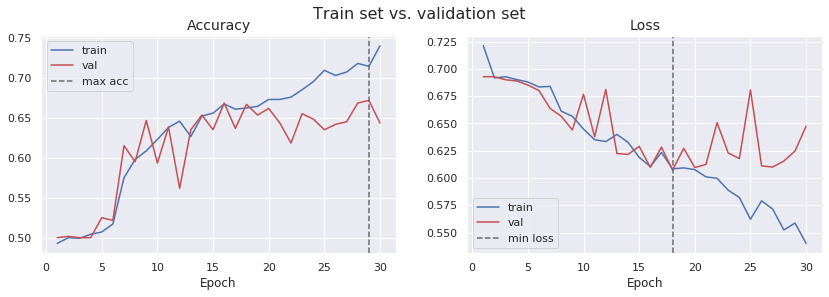

After 29 epochs the maximum validation accuracy is 67.17%
After 18 epochs the maximum validation loss is 0.61


In [132]:
plotHistory(history_1)

Right from the start we see this model is strongly overfitting as the training accuracy is very high, but the validation accuracy is much lower and does not improve over time.

#### Experiment 2

In [52]:
# Because our previous model was overfitting, we will reduce the number of parameters in the model by removed one Dense layer
model_2 = keras.Sequential()

model_2.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2,2)))
model_2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2,2)))
model_2.add(layers.Flatten())
#model_2.add(layers.Dense(units=16, activation='relu')) ############## REMOVED THIS DENSE LAYER
model_2.add(layers.Dense(units=8, activation='relu'))
model_2.add(layers.Dense(units=1, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

Note this model has 144,753 trainable parameters compared to the 280,065 in the previous model.

In [54]:
history_2 = model_2.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

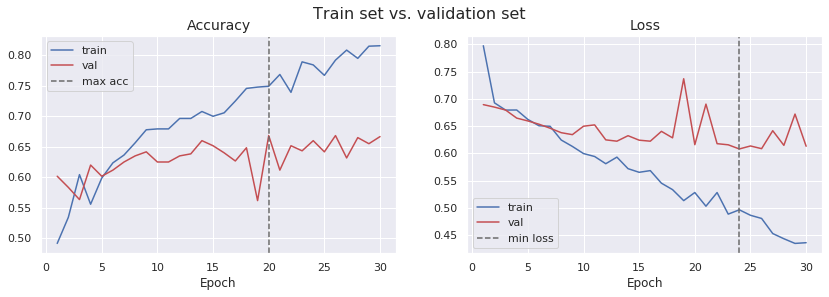

After 20 epochs the maximum validation accuracy is 66.83%
After 24 epochs the maximum validation loss is 0.61


In [127]:
plotHistory(history_2)

We still observe overfitting occuring, so let's try to add some regularization by applying l2 regularization.

#### Experiment 3

In [56]:
# Applying l2 regularization to avoid overfitting
model_3 = keras.Sequential()

model_3.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=(2,2)))
model_3.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=(2,2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(layers.Dense(units=1, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

Note this model contains l2 regularizaiton in the second to last dense layer.

In [58]:
history_3 = model_3.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

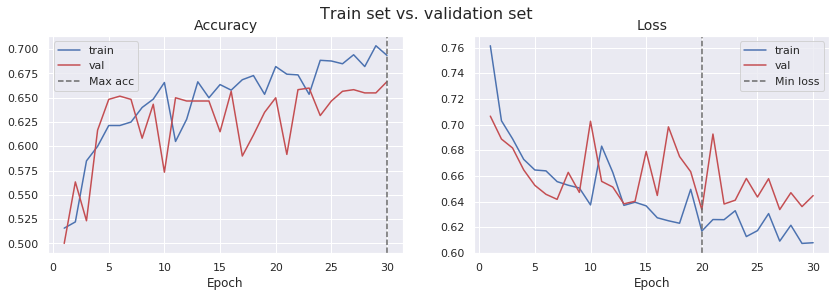

After 30 epochs the maximum validation accuracy is 0.6666666865348816
After 20 epochs the maximum validation loss is 0.6336400119463602


In [106]:
plotHistory(history_3)

Using l2 regularization the model appears to be overfitting less, let's see if this also holds for l1 regularization


#### Experiment 4

In [60]:
# Applying l1 regularization
model_4 = keras.Sequential()

model_4.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_4.add(layers.MaxPooling2D(pool_size=(2,2)))
model_4.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_4.add(layers.MaxPooling2D(pool_size=(2,2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_4.add(layers.Dense(units=1, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
model_4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

Note this model contains l1 regularization in the second to last dense layer.

In [62]:
history_4 = model_4.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

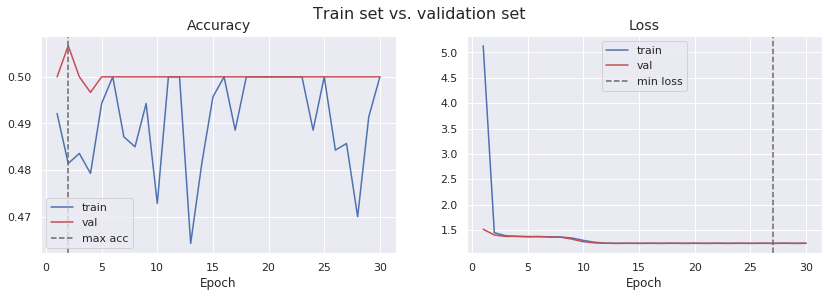

After 2 epochs the maximum validation accuracy is 50.67%
After 27 epochs the maximum validation loss is 1.24


In [129]:
plotHistory(history_4)

Here we see that the model is not learning anything (underfitting) as the prediction accuracy does not improve above 50%. Next let's see how dropout works as an regularization strategy.

#### Experiment 5

In [64]:
# Applying dropout regularization
model_5 = keras.Sequential()

model_5.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_5.add(layers.MaxPooling2D(pool_size=(2,2)))
model_5.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_5.add(layers.MaxPooling2D(pool_size=(2,2)))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(units=8, activation='relu'))
model_5.add(layers.Dropout(0.25))
model_5.add(layers.Dense(units=8, activation='relu'))
model_5.add(layers.Dense(units=1, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
model_5.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)               

Note this model contains dropout regularizaiton after the first fully connected dense layer.

In [66]:
history_5 = model_5.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

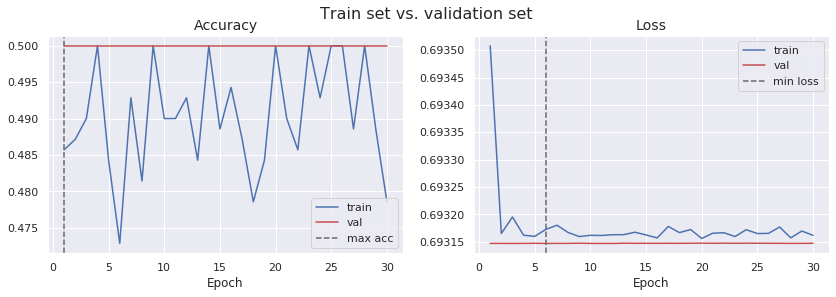

After 1 epochs the maximum validation accuracy is 50.00%
After 6 epochs the maximum validation loss is 0.69


In [130]:
plotHistory(history_5)

Here we see again that the model is not learning anything (underfitting) as the prediction accuracy does not improve above 50%. Next let's see if dropout regularization works better if we add more parameters by introducing another fully connected layer.

#### Experiment 6

In [68]:
# Applying dropout regularization with an additional fully connected layer
model_6 = keras.Sequential()

model_6.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_6.add(layers.MaxPooling2D(pool_size=(2,2)))
model_6.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_6.add(layers.MaxPooling2D(pool_size=(2,2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(units=8, activation='relu'))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(units=8, activation='relu'))
model_6.add(layers.Dense(units=1, activation='sigmoid'))
model_6.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
model_6.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)               

Note this model contains l1 regularizaiton in the second to last dense layer.

In [70]:
history_6 = model_6.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

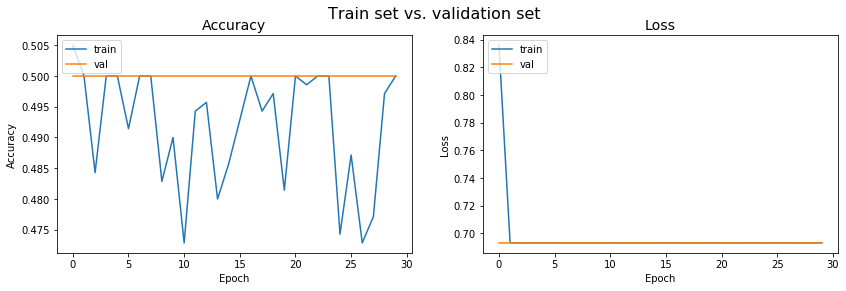

In [71]:
plotHistory(history_6)

Again we see no improvement in accuracy during epochs and the model is simply performing at baseline. Let's continue with l2 regularization for now and see if we can achieve better results by adding an additional convolutional layer.

#### Experiment 7

In [74]:
# Adding an additional convolutional layer along with l2 regluarization
model_7 = keras.Sequential()

model_7.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2,2)))
model_7.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2,2)))
model_7.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_7.add(layers.MaxPooling2D(pool_size=(2,2)))
model_7.add(layers.Flatten())
model_7.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(layers.Dense(units=1, activation='sigmoid'))
model_7.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
model_7.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 11, 10, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3520)            

Note this model contains an additional convolutional layer.

In [76]:
history_7 = model_7.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

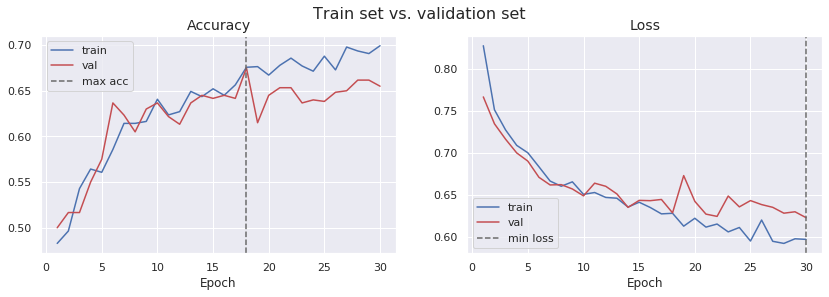

After 18 epochs the maximum validation accuracy is 67.50%
After 30 epochs the maximum validation loss is 0.62


In [131]:
plotHistory(history_7)

Adding the additional convolution layer did not seem to boost the accuracy of the model a whole lot. Instead let's try to add more filters to the existing two conv layers.


#### Experiment 8

In [133]:
# Increased number of filters from 32 to 48 for both conv layers
model_8 = keras.Sequential()

model_8.add(layers.Conv2D(filters=48, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_8.add(layers.MaxPooling2D(pool_size=(2,2)))
model_8.add(layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'))
model_8.add(layers.MaxPooling2D(pool_size=(2,2)))
model_8.add(layers.Flatten())
model_8.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_8.add(layers.Dense(units=1, activation='sigmoid'))
model_8.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [134]:
model_8.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 101, 94, 48)       480       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 50, 47, 48)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 48, 45, 48)        20784     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 24, 22, 48)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 25344)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 202760    
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

Note this model uses 48 filters for each convolution layer instead of 32.

In [135]:
history_8 = model_8.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

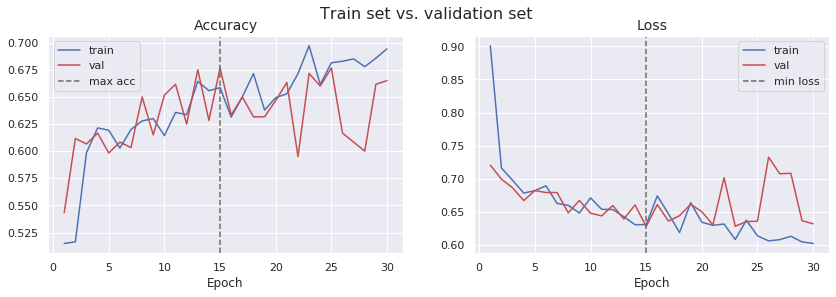

After 15 epochs the maximum validation accuracy is 67.67%
After 15 epochs the maximum validation loss is 0.63


In [136]:
plotHistory(history_8)

Adding additional filters did not have much of an affect on the accuracy of the model. Next let's try to implement a different optimizer.


#### Experiment 9

In [137]:
# Changed the optimizer from 'rmsprop' to 'adam'
model_9 = keras.Sequential()

model_9.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_9.add(layers.MaxPooling2D(pool_size=(2,2)))
model_9.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_9.add(layers.MaxPooling2D(pool_size=(2,2)))
model_9.add(layers.Flatten())
model_9.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_9.add(layers.Dense(units=1, activation='sigmoid'))
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [138]:
model_9.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

Note this model uses 'adam' as the optimizer instead of 'rmsprop'.

In [139]:
history_9 = model_9.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

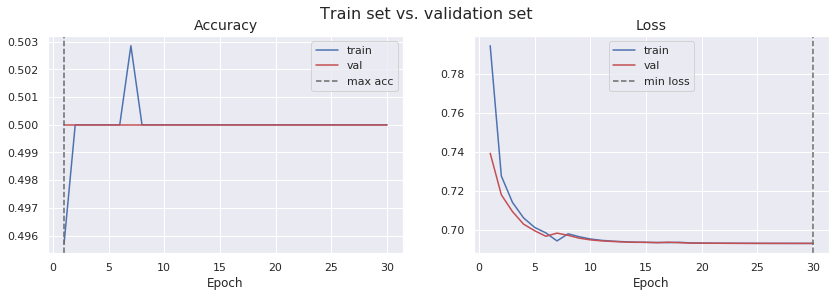

After 1 epochs the maximum validation accuracy is 50.00%
After 30 epochs the maximum validation loss is 0.69


In [140]:
plotHistory(history_9)

Changing the optimizer to 'adam' clearly had a negative effect on the model's performance. Let's now try to apply 'sgd'.


#### Experiment 10

In [141]:
# Changed the optimizer to 'sgd'
model_10 = keras.Sequential()

model_10.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_10.add(layers.MaxPooling2D(pool_size=(2,2)))
model_10.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_10.add(layers.MaxPooling2D(pool_size=(2,2)))
model_10.add(layers.Flatten())
model_10.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_10.add(layers.Dense(units=1, activation='sigmoid'))
model_10.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
model_10.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

Note this model uses 'sgd' as its optimizer

In [143]:
history_10 = model_10.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

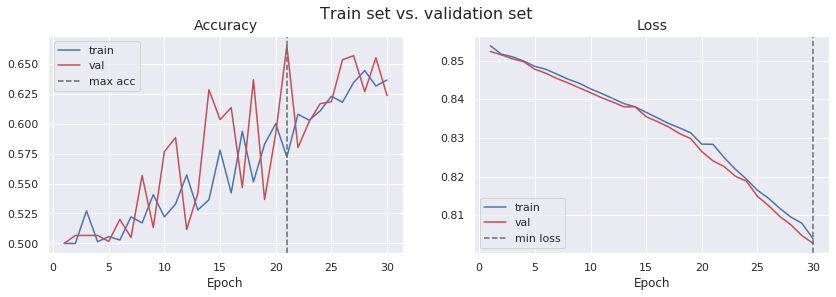

After 21 epochs the maximum validation accuracy is 66.50%
After 30 epochs the maximum validation loss is 0.80


In [144]:
plotHistory(history_10)

Looking at the graphs it appears that the model was still learning (increasing accuracy/decreasing loss) as it completed the last epoch. Let's try to run this same model again for 100 epochs to get an idea how much improvement we could get out more epochs.

#### Experiment 11

In [145]:
# Running this model for 100 epochs with sgd as the optimizer
model_11 = keras.Sequential()

model_11.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_11.add(layers.MaxPooling2D(pool_size=(2,2)))
model_11.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_11.add(layers.MaxPooling2D(pool_size=(2,2)))
model_11.add(layers.Flatten())
model_11.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_11.add(layers.Dense(units=1, activation='sigmoid'))
model_11.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [146]:
model_11.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 16896)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 135176    
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

Note this model uses 'sgd' as its optimizer

In [147]:
history_11 = model_11.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

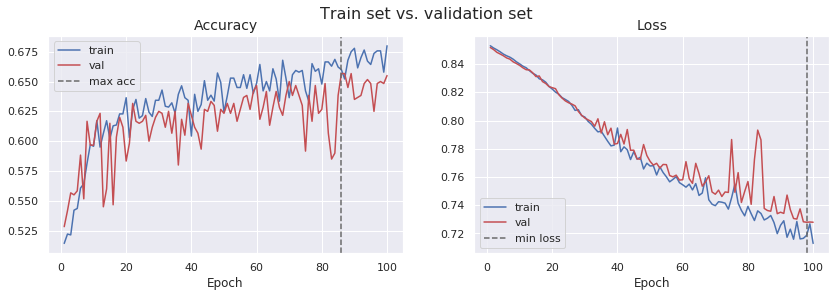

After 86 epochs the maximum validation accuracy is 65.67%
After 98 epochs the maximum validation loss is 0.73


In [148]:
plotHistory(history_11)

Despite the 100 epochs, the model did not improve beyond 67% accuracy seen before. Next we can try to adjust the learning rate of our model.

#### Experiment 12

In [13]:
# Running this model for 100 epochs with sgd as the optimizer
model_12 = keras.Sequential()

model_12.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_12.add(layers.MaxPooling2D(pool_size=(2,2)))
model_12.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_12.add(layers.MaxPooling2D(pool_size=(2,2)))
model_12.add(layers.Flatten())
model_12.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_12.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
model_12.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model_12.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 135176    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1.

In [15]:
history_12 = model_12.fit(X_gender_train, y_gender_train, 
                          batch_size=128, 
                          epochs=100, 
                          verbose=0, 
                          validation_data=(X_gender_val, y_gender_val))

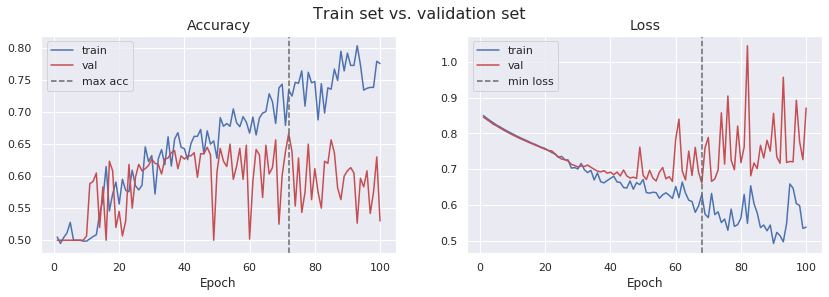

After 72 epochs the maximum validation accuracy is 66.67%
After 68 epochs the maximum validation loss is 0.66


In [19]:
plotHistory(history_12)

Again we notice overfittig as can be clearly seen in the loss figure. After 30-40 epochs the train loss continues to decline while the validation loss starts stagnate or even get worse. Let's try a learning rate of 0.001 next.

#### Experiment 13

In [20]:
# Running this model for 100 epochs with a learning rate of 0.001
model_13 = keras.Sequential()

model_13.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_13.add(layers.MaxPooling2D(pool_size=(2,2)))
model_13.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_13.add(layers.MaxPooling2D(pool_size=(2,2)))
model_13.add(layers.Flatten())
model_13.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_13.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.001, decay=0, momentum=0, nesterov=False)
model_13.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model_13.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 101, 94, 32)       320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 22, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 135176    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

Note this model uses 'sgd' as its optimizer with a learning rate of 0.001.

In [22]:
history_13 = model_13.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

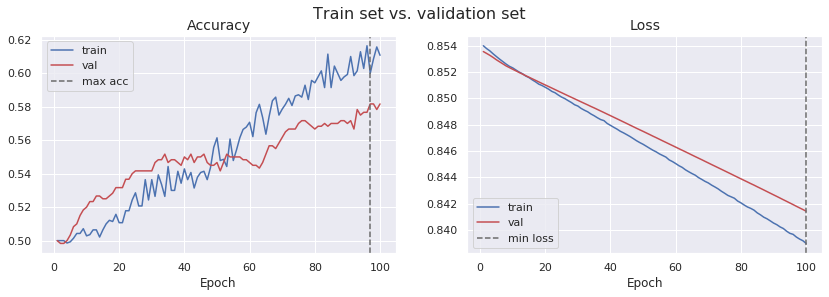

After 97 epochs the maximum validation accuracy is 58.17%
After 100 epochs the maximum validation loss is 0.84


In [23]:
plotHistory(history_13)

While the validation accuracy was still increasing, after around 50 epochs we notice that we started to overfit as the train accuracy kept increasing and the validation accuracy slowed down. Let's go back to the default learning rate of 0.1 and implement some momentum. 

#### Experiment 14

In [24]:
# Running this model for 30 epochs using sgd with a momentum of 0.9
model_14 = keras.Sequential()

model_14.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_14.add(layers.MaxPooling2D(pool_size=(2,2)))
model_14.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_14.add(layers.MaxPooling2D(pool_size=(2,2)))
model_14.add(layers.Flatten())
model_14.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_14.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=0, momentum=0.9, nesterov=False)
model_14.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1 and momentum of 0.9.

In [28]:
# Result of third model
history_14 = model_14.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

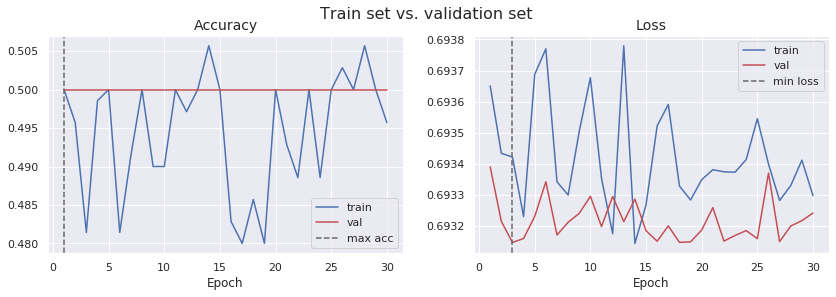

After 1 epochs the maximum validation accuracy is 50.00%
After 3 epochs the maximum validation loss is 0.69


In [29]:
plotHistory(history_14)

It is clear that by applying a momentum of 0.9, the model is unable to learn anything. Let's try again with a lower momentum value of 0.1.

#### Experiment 15

In [30]:
# Running this model for 30 epochs using sgd with a momentum of 0.1
model_15 = keras.Sequential()

model_15.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_15.add(layers.MaxPooling2D(pool_size=(2,2)))
model_15.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_15.add(layers.MaxPooling2D(pool_size=(2,2)))
model_15.add(layers.Flatten())
model_15.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_15.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=0, momentum=0.1, nesterov=False)
model_15.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1 and momentum of 0.1.

In [31]:
history_15 = model_15.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

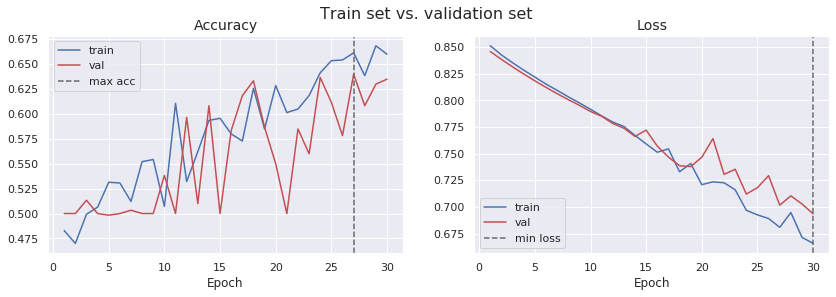

After 27 epochs the maximum validation accuracy is 64.00%
After 30 epochs the maximum validation loss is 0.69


In [32]:
plotHistory(history_15)

A smaller momentum value appears to be working much better. After only 30 epochs we reached an validation accuracy of 64%. Before trying it for more epochs, let's see if Nesterov momentum gives better results.

#### Experiment 16

In [60]:
# Running this model for 30 epochs using sgd with nesterov momentum of 0.1
model_16 = keras.Sequential()

model_16.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_16.add(layers.MaxPooling2D(pool_size=(2,2)))
model_16.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_16.add(layers.MaxPooling2D(pool_size=(2,2)))
model_16.add(layers.Flatten())
model_16.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_16.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=0, momentum=0.1, nesterov=True)
model_16.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1 and Nesterov momentum of 0.1.

In [61]:
history_16 = model_16.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

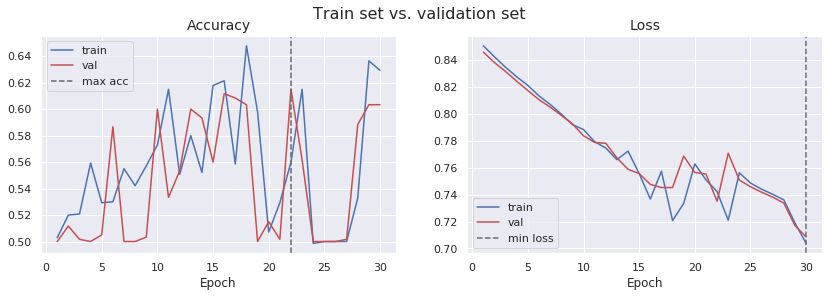

After 22 epochs the maximum validation accuracy is 61.50%
After 30 epochs the maximum validation loss is 0.71


In [62]:
plotHistory(history_16)

Nesterov momentum appears to be slight worse. Let's try to run use regular momentum for 100 epoch and see if we get improvement beyond 64%

#### Experiment 17

In [39]:
# Running this model for 100 epochs using sgd with momentum of 0.1
model_17 = keras.Sequential()

model_17.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
model_17.add(layers.MaxPooling2D(pool_size=(2,2)))
model_17.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_17.add(layers.MaxPooling2D(pool_size=(2,2)))
model_17.add(layers.Flatten())
model_17.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_17.add(layers.Dense(units=1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=0, momentum=0.1, nesterov=False)
model_17.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1 and momentum of 0.1.

In [40]:
history_17 = model_17.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=100, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

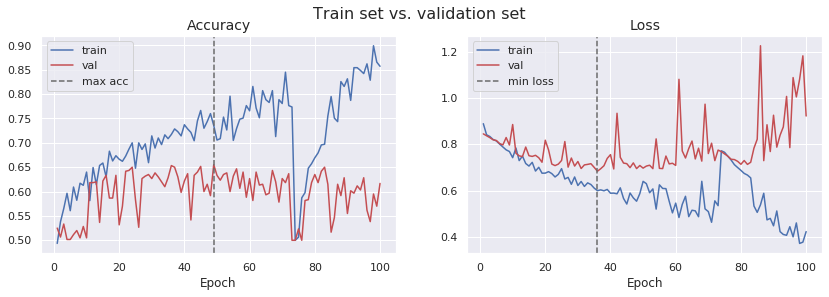

After 49 epochs the maximum validation accuracy is 65.50%
After 36 epochs the maximum validation loss is 0.68


In [41]:
plotHistory(history_17)

Even with more epochs the model is unable to get higher validation accuracy and starts overfitting already around epoch 20. Given that the manual tuning has given us little improvement, let's try to investigate bigger search space by applying baysian optimization.

#### Experiment 18

In [9]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [20]:
# Create function for random model
def simpleModel(X_gender_train, y_gender_train, X_gender_val, y_gender_val):
    model = keras.Sequential()

    model.add(layers.Conv2D({{choice([16,24,32,40])}}, kernel_size=(3,3), input_shape=(103,96,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D({{choice([16,24,32,40])}}, kernel_size=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2({{choice([0.01, 0.05, 0.1, 0.2])}})))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer={{choice(['rmsprop', 'adam', 'sgd'])}}, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_gender_train, y_gender_train, 
                        batch_size={{choice([32,64,128])}}, 
                        epochs={{choice([30,50,100])}}, 
                        verbose=0 
                        validation_data=(X_gender_val, y_gender_val))
    
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


SyntaxError: invalid syntax (<ipython-input-20-746d64224d3b>, line 19)

In [16]:
def data():
    
    #from load_data import imageImport, getLabel
    
    REAL = '/mnt/c/Users/Meekmar/Github/finger-prints/SOCOFing/Real'

    # Load the data | (img, (gender-label, hand-label, finger-lable))
    data = imageImport(REAL)

    # Splits the train-test in the same way as the paper did (I added an additional train-validation split for tuning of the model)
    X_gender_train, X_gender_val, X_gender_test, y_gender_train, y_gender_val, y_gender_test = genderTrainTestSplit(data, 1000, 230)
    
    # Reshape the input arrays
    X_gender_train = np.array(X_gender_train).reshape(-1, 103, 96, 1)
    X_gender_val = np.array(X_gender_val).reshape(-1, 103, 96, 1)
    X_gender_test = np.array(X_gender_test).reshape(-1, 103, 96, 1)
    
    return X_gender_train, y_gender_train, X_gender_val, y_gender_val

In [19]:
best_run, best_model = optim.minimize(model=simpleModel,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='simple_notebook')

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import cv2
except:
    pass

try:
    import random
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from load_data import *
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras import layers, regularizers, optimizers
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'Conv2D': hp.choice('Conv2D', [16,24,32,40]),
        'Conv2D_1': hp.choice('Conv2D_1', [16,24,32,40]),
        'l2': 

KeyboardInterrupt: 

Note this model uses 'sgd' as its optimizer with a learning rate of 0.1 and momentum of 0.1.

In [56]:
# Result of third model
history_18 = model_18.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

In [58]:
# Result of third model
history_test = model_18.fit(X_gender_train, y_gender_train, 
                    batch_size=128, 
                    epochs=30, 
                    verbose=0, 
                    validation_data=(X_gender_val, y_gender_val))

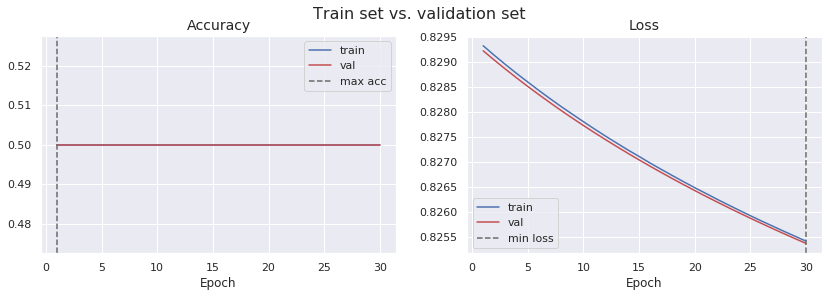

After 1 epochs the maximum validation accuracy is 50.00%
After 30 epochs the maximum validation loss is 0.83


In [59]:
plotHistory(history_test)

It is clear that by applying a momentum of 0.9, the model is unable to learn anything. Let's try again with a lower momentum value of 0.1.